# Machine Learning Interpretability with Shapley values

Shapley values give the contribution of each feature in an example of interest to the model prediction.

Other recources:

I thoroughly recommend this YouTube video from 'Machine Learning Dojo with Tim Scarfe':
https://youtu.be/jhopjN08lTM

Christopher Molner has an excellent online book with details on Shapley values:
https://christophm.github.io/interpretable-ml-book/shapley.html

There is also a good interview with Chris Molner on YouTube in machine Learning Street Talk: https://youtu.be/0LIACHcxpHU

Documentation for the SHAP library: https://shap.readthedocs.io/en/latest/index.html

Talk on the SHAP library by Scott Lunberg, a key author of the SHAP library: https://youtu.be/B-c8tIgchu0

## First set up Google Colab

First ensure you have selected GPU from 'runtime' / 'change runtime type'. This may require you then to restart the runtime.

Then run the code below to change TensorFlow version to 2.2.0. 

AFTER RUNNING THIS CELL PLEASE RESTART THE RUNTIME.

In [1]:
# Select 'GPU' from 'runtime' / 'change runtime type'

downgrade_tensorflow = True

import tensorflow
print(tensorflow.__version__)

if downgrade_tensorflow and tensorflow.__version__ != '2.2.0':
    !pip uninstall tensorflow
    !pip install tensorflow==2.2.0
    import tensorflow
    print(tensorflow.__version__)

2.2.0


## Shapley Values - Intuition

### Shapley values in game theory

The origin of Shapley values is in game theory, and is used to provide a fair determination of the value each player makes in a coalition [1].

Imagine we have three players who play together in a coalition in a pub quiz. Together they win £100 on average. How should their winnings be split to fairly compensate each person for contribution to the collective winnings?

Shapley values is one way to get at this, and goes like this. Imagine the coalition being formed one quiz player at a time, and the value of the player is the difference in winnings by adding in that one player.

So player A alone may win £75, and so in this case adds a value of £75. Player A+B together win £90 and so player B has added £15 of value vs. player A alone. Players ABC together win £100, so player C has added £10 of value on top of player A.

But - some questions are easier and all may know the answer. If we only have one order of addition then the first player (who plays alone) will seem to have the hightest value. Player B can only add value to those questions that player A does not know the answer to, and player C can only add value to those questions that players A and B together do not know the answer to.

So a full Shapley analysis has all permutations, allowing all players to be first, and second to other players, and third. The table below shows all the permutations. Those in italics have been performed before and would not need repeating (player combination A+B is the same as player combination B+A).

Permutation| Sequence to test
---|---
ABC | A, AB, ABC
ACB | *A*, AC, *ACB*
BAC | B, *BA*, *BAC*
BCA | *B*, BC, *BCA*
CAB | C, CA, *CAB*
CBA | *C*, *BA*, *CBA*

For each combination tested (including single players) we calulcate the value they added in the step-wise addition of players. We then average the added value each player makes in different combinations. That average gives us the average marginal contribution each player makes. The sum of these average marginal contribution will add up to average winnings of the whole team playing together.

### Shapley values in machine learning

So what is the link to machine learning?

Shapley values provide a measure of contribution made by different features to a prediction.

Imagine I have three features for prediction of house price: size, number of bedrooms, area crime rate. I am interested in knowing, using any type of machine learning model, the contribution each feature made to a prediction.

In Shapley values in machine learning the total contribution features make to a prediction is the difference in prediction for that particular instance compared with the mean value for the whole population. In the case of house prices, if I am given no feature information then all my predictions will just be the average price. As I add in features (in different combinations) I get closer to the prediction using all information (features).

Here we are likely to have covariance between features - that is they are linked. The size of a property is likely to have some relationship with the number of rooms. And perhaps larger houses are also built in lower crime areas. So again the first feature added will probably grab much of the total prediction value, just like the first pub quiz player grabbed much of the total winnings. So, as with my pub quiz team I can run all combinations of adding features, fitting the model to each combination and calculating the value added (difference between that prediction and just the average house price) by different features. I then average the value added for each feature across all permutations tested.

### Four key properties of Shapley properties

Shapley values obey four key properties of explainability:

* *Efficiency*: The feature contributions add up to the difference in the prediction for x from the average.

* *Symmetry*: The contributions of two features values are the same if they contribute equaly to all possible combinations of features used. This is also called *equal treatment of equals*

* *Additivity* or *Linearity*: The prediction in any case should be proportional to the Shapley values for that case. Suppose you trained a random forest, which means that the prediction is an average of many decision trees. The Additivity property guarantees that for a feature value, you can calculate the Shapley value for each tree individually, average them, and get the Shapley value for the feature value for the random forest.

* *Nullity* or *Dummy*: If a feature does not improve preidction then the Shapley value for that feature should be zero.If a feature does not improve preidction then the Shapley value for that feature should be zero.

## Shapley values in practice

The above gives the intuition behind Shapley values, but it is rare that we can do this in practice. As the number fo features grow, the number of permutations explode - giving us an unfeasible number of models to fit and test.

So, two methods can be used (and these days, the second method, the SHAP library, is almost universally used).

### Shapley sampling

In Shapley sampling we use a couple of tricks to make the problem more computationally acceptable:

1) We do not refit models excluding features, but rather we approximate the model fit without a feature, by replacing that feature value either with the mean or median value of that feature across all values, or by replacing that feature value with a random sample from the population (and we are likely to repeat this to get a number of estimates).

2) We sample from possible permutaions and take the mean. As the number of samples increases the mean sampled Shapely estimate will tend towards the true Shapley value.

Strumbelj et al. [2] provided the following method, which tests the value of adding feature *j* in combination with any other feature values:

To estimate for Shapley values for any instance of interest, *x*:

Repeat for each feature, *j*:

  * Repeat the following for *m* iterations:
  
    * Draw a random instance, *z* from the population

    * Choose a random order of feature values

    * Create two hybrid instances. Both are identical up to, and after, feature *j*, but one instance takes the value of *j* from our instance of interest *x*, and the other from our random sample, *z*:
      
      1. Use values from *x* for all feature values up to *and including* feature *j*, and then use values from *z* for the remaining feature values.
      2. Use values from *x* for all feature values up to *but not including* feature *j*, and then use values from *z* for the remaining feature values, including feature *j*.
     
     * Compute the marginal contribution of feature *j* by taking model estimates of hybrid instances with and without *j* from *x*: *f(x+j)* - *f(x-j*)
      
      * Computer the Shapley value for *j* in instance *x* as the average of the m* iterations

### SHAP 

SHAP is a python Library with efficient algorithms for estimatign Shapley values. For more details see:

https://shap.readthedocs.io/en/latest/

https://github.com/slundberg/shap

Lundberg, A. and Lee, S-I (2017) A Unified Approach to Interpreting Model Predictions. arXiv:1705.07874 https://arxiv.org/abs/1705.07874


Here, we will use the SHAP library,

### References

[1]  Shapley, Lloyd S. (August 21, 1951). "Notes on the n-Person Game -- II: The Value of an n-Person Game" (PDF). Santa Monica, Calif.: RAND Corporation. https://www.rand.org/content/dam/rand/pubs/research_memoranda/2008/RM670.pdf

[2] Štrumbelj, Erik, and Igor Kononenko. "Explaining prediction models and individual predictions with feature contributions." Knowledge and information systems 41.3 (2014): 647-665

## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

# Install shap if necessary (e.g. running in Google Colab)
try:
    import shap
except:
    !pip install shap
    import shap

In [3]:
# This is the code from:
# https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

# Get mnist data set from keras datasets
from tensorflow.keras.datasets import mnist

batch_size = 32
num_classes = 10
epochs = 50

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Set up CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Fit model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/50
1875/1875 - 11s - loss: 2.2723 - accuracy: 0.1904 - val_loss: 2.2197 - val_accuracy: 0.5028
Epoch 2/50
1875/1875 - 9s - loss: 2.1586 - accuracy: 0.3963 - val_loss: 2.0497 - val_accuracy: 0.6634
Epoch 3/50
1875/1875 - 9s - loss: 1.9457 - accuracy: 0.5225 - val_loss: 1.7507 - val_accuracy: 0.7289
Epoch 4/50
1875/1875 - 9s - loss: 1.6344 - accuracy: 0.6030 - val_loss: 1.3570 - val_accuracy: 0.7798
Epoch 5/50
1875/1875 - 9s - loss: 1.3092 - accuracy: 0.6610 - val_loss: 1.0127 - val_accuracy: 0.8076
Epoch 6/50
1875/1875 - 9s - loss: 1.0763 - accuracy: 0.6993 - val_loss: 0.7937 - val_accuracy: 0.8295
Epoch 7/50
1875/1875 - 9s - loss: 0.9217 - accuracy: 0.7291 - val_loss: 0.6604 - val_accuracy: 0.8470
Epoch 8/50
1875/1875 - 9s - loss: 0.8296 - accuracy: 0.7496 - val_loss: 0.5793 - val_accuracy: 0.8587
Epoch 9/50
1875/1875 - 9s - loss: 0.7598 - accuracy: 0.7688 - val_loss: 0.5229 - val_accuracy: 0.8689
Epoch 10

We need to set a background that individual instances will be compared against. We will select 250 images at random.

In [4]:
# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 250, replace=False)]

For TensforFlow neural nets we use SHAP's `DeepExplainer` method.

In [5]:
explainer = shap.DeepExplainer(model, background)
# ...or we could pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

## Get Shapley values

For DeepExplainer we use the `explainer.shap_values` method, which gives us just the Shapley values alone.

In [6]:
shap_values = explainer.shap_values(x_test[1:5])

Show Shapley values in a plot, and here we demonstrate how to save a plot (which can be used on other plots apart from `force` plots).

Shap values for ten possible clasees of four images
Predictions: [2, 1, 0, 4]


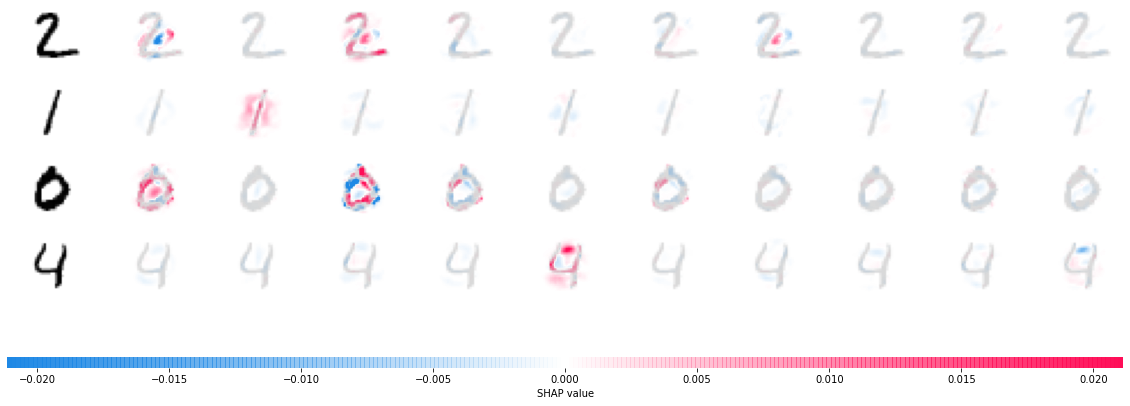

In [7]:
# Get predictions of four examples
predictions = model.predict(x_test).argmax(axis=1)
print ('Shap values for ten possible clasees of four images')
print ('Predictions:', list(predictions[1:5]))

# Get Shapley value plot for five values
shap.image_plot(shap_values, -x_test[1:5], show=False)
# Put image in f
f = plt.gcf()
f.savefig('shap_image.jpg', dpi=600)